In [21]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import sklearn, sklearn.linear_model, sklearn.ensemble, sklearn.model_selection, sklearn.metrics, sklearn.preprocessing

model_fname = 'graph_mobilenet_0.50_224.pb'
model_imgdim = (224, 224, 3)
model_num_features = 1001
data_path = 'data'
img_features_cache = 'img_features.csv'
img_feature_format = 'f{0:04d}'

In [95]:
def tf_create_mobilenet_graph(model_fname):
    t_input = 'input:0'
    t_output = 'MobilenetV1/Predictions/Reshape:0'
    tf_graph_def = tf.GraphDef()
    with open(model_fname, 'rb') as f:
        tf_graph_def.ParseFromString(f.read())
    tf_input, tf_output = tf.import_graph_def(tf_graph_def, name='', return_elements=[t_input, t_output])
    
    return tf_input, tf_output


def tf_create_jpeg_load_graph(dst_dim):
    tf_input_jpeg = tf.placeholder(tf.string)
    tf_input_img = tf.cast(tf.image.decode_jpeg(tf_input_jpeg, channels=dst_dim[2]), dtype=tf.float32)
    tf_resized_img = tf.image.resize_bilinear(tf.expand_dims(tf_input_img, 0), tf.cast(tf.stack([dst_dim[0], dst_dim[1]]), dtype=tf.int32))
    tf_final_img = (tf_resized_img - 127.5) / 127.5
    return tf_input_jpeg, tf_final_img

def tf_get_features(img_fnames, model_fname, img_dim, verbose=False):
    tf.reset_default_graph()
    
    tf_input_cnn, tf_output_cnn = tf_create_mobilenet_graph(model_fname)
    tf_input_jpeg, tf_output_img = tf_create_jpeg_load_graph(img_dim)
    
    with tf.Session() as tfs:
        res = []
        num_current = 1
        num_total = len(img_fnames)
        for img_fname in img_fnames:
            img_data = None
            with open(img_fname, 'rb') as f:
                img_data = f.read()
            img_transformed = tf_output_img.eval(feed_dict={tf_input_jpeg:img_data})
            img_features = tf_output_cnn.eval(feed_dict={tf_input_cnn:img_transformed})
            res.append(img_features)
            if not verbose:
                print('{0} of {1} processed...'.format(num_current, num_total), end='\r')
                num_current += 1
    return np.vstack(res)

def tf_get_images(img_fnames):
    tf.reset_default_graph()
    tf_input_jpeg = tf.placeholder(tf.string)
    tf_res_img = tf.image.decode_jpeg(tf_input_jpeg)
    res = []
    with tf.Session() as tfs:
        for img_fname in img_fnames:
            img_data = None
            with open(img_fname, 'rb') as f:
                img_data = f.read()
            res.append(tf_res_img.eval(feed_dict={tf_input_jpeg:img_data}))
    return res

In [3]:
def get_all_files(path):
    return [(os.path.join(path, f), f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

def get_all_dirs(path):
    return [(os.path.join(path, f), f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

def gather_features(path, model_fname, img_dim, verbose=False):
    dirs = get_all_dirs(path)
    all_files = []
    all_labels = []
    for (dp, label) in dirs:
        image_fnames = get_all_files(dp)
        fnames = list(list(zip(*image_fnames))[0])
        all_files += fnames
        all_labels += [label]*len(fnames)
    all_features = tf_get_features(all_files, model_fname, img_dim, verbose)
    dic = {img_feature_format.format(i):all_features[:,i] for i in range(all_features.shape[1])}
    dic.update({'file':all_files, 'label':all_labels})
    return pd.DataFrame(dic)

### Gather features once to .csv file

In [33]:
res = gather_features(data_path, model_fname, model_imgdim)
res.to_csv(img_features_cache, index=False)

### Analyze only final layer CNN features from created .csv
True labels are only 'beach', 'food', 'pet' and 'bar'. Label 'bar' quality is astoundingly bad.

In [4]:
src = pd.read_csv(img_features_cache)

In [26]:
features = [img_feature_format.format(i) for i in range(model_num_features)]
targets = ['beach', 'bar', 'food', 'pet']

src_dev = src[src.label.isin(targets)]

Xdev = src_dev[features].values
trgBinarizer = sklearn.preprocessing.LabelBinarizer().fit(src_dev.label)
Ydev = trgBinarizer.transform(src_dev.label)

In [34]:
Xdev.shape, Ydev.shape, trgBinarizer.classes_

((3324, 1001), (3324, 4), array(['bar', 'beach', 'food', 'pet'],
       dtype='<U5'))

In [35]:
Xtrain, Xtest, Ytrain, Ytest = sklearn.model_selection.train_test_split(Xdev, Ydev, test_size=0.3)

In [36]:
%%time
lin_models = []
for i in range(Ytrain.shape[1]):
    lin_models.append(sklearn.linear_model.LogisticRegression().fit(Xtrain, Ytrain[:,i]))    

Wall time: 3.78 s


In [41]:
%%time
gb10_models = []
for i in range(Ytrain.shape[1]):
    gb10_models.append(sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=10).fit(Xtrain, Ytrain[:,i]))    

Wall time: 1min 15s


In [40]:
%%time
gb02_models = []
for i in range(Ytrain.shape[1]):
    gb02_models.append(sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=2).fit(Xtrain, Ytrain[:,i]))    

Wall time: 1min 15s


In [87]:
def model_metrics(model, X, Y):
    gini = sklearn.metrics.roc_auc_score(Y,model.predict_proba(X)[:,1])*2-1
    acc = sklearn.metrics.accuracy_score(Y,model.predict(X))
    return (gini, acc)

def assess_models(models, X, Y, mapping=None):
    res = []
    for i in range(len(models)):
        res.append(model_metrics(models[i], X, Y[:,i]))
    if mapping is not None:
        res = [(mapping[i], x[0],x[1]) for (i,x) in enumerate(res)]
    return res

def apply_models(df, features, models, mapping, fcst_format='fcst_{0}'):
    X = df[features].values
    for i in range(len(models)):
        df[fcst_format.format(mapping[i])] = models[i].predict_proba(X)[:,1]

def compare_models(models, samples, mapping=None, model_mapping=None,
                   sample_mapping=['Train','Test'], metrics_mapping=['Gini','Accuracy']):
    df_res = None
    for i in range(len(models)):
        cols = []
        colnames = [('Model', 'Name'),('Model', 'Target')]
        rowvalues = None
        for j in range(len(samples)):
            X = samples[j][0]
            Y = samples[j][1]
            res = assess_models(models[i], X, Y, mapping=mapping)
            colnames += [(sample_mapping[j], x) for x in metrics_mapping]
            tmpvals = np.array([[x[1],x[2]] for x in res])
            if rowvalues is None:
                rowvalues = tmpvals
            else:
                rowvalues = np.hstack([rowvalues, tmpvals])
                
        rowvalues = np.hstack([np.array([[model_mapping[i]] * len(mapping), mapping]).transpose(), rowvalues])
        tmpres = pd.DataFrame(data=rowvalues, columns = pd.MultiIndex.from_tuples(colnames))
        if df_res is None:
            df_res = tmpres
        else:
            df_res = df_res.append(tmpres)
    return df_res


In [39]:
assess_models(lin_models, Xtest, Ytest, mapping=trgBinarizer.classes_)

[('bar', 0.9304073902288188, 0.9238476953907816),
 ('beach', 0.9847727959749355, 0.97595190380761521),
 ('food', 0.98165767482848887, 0.96793587174348694),
 ('pet', 0.99840863881784592, 0.98997995991983967)]

In [80]:
compare_models([lin_models, gb10_models, gb02_models], [(Xtrain, Ytrain),(Xtest, Ytest)],
               mapping=trgBinarizer.classes_, model_mapping=['LogReg', 'GB-10', 'GB-02'])

Model                      Train                                    Test  \
     Name Target                Gini            Accuracy                Gini   
0  LogReg    bar    0.99999640439419   0.999140154772141  0.9304073902288188   
1  LogReg  beach  0.9999960036766173   0.999140154772141  0.9847727959749355   
2  LogReg   food                 1.0                 1.0  0.9816576748284889   
3  LogReg    pet                 1.0                 1.0  0.9984086388178459   
0   GB-10    bar  0.9996044833608848  0.9926913155631987  0.9533955627705626   
1   GB-10  beach  0.9999940055149261   0.999140154772141  0.9833996833643308   
2   GB-10   food                 1.0                 1.0  0.9899578331463237   
3   GB-10    pet                 1.0                 1.0  0.9970304063654447   
0   GB-02    bar  0.9995253800330615  0.9935511607910577  0.9543425324675325   
1   GB-02  beach  0.9999940055149263   0.999140154772141   0.982277624925068   
2   GB-02   food                 1.0                 1.0  0.9906238952335573   
3   GB-02    pet                 1.0                 1.0  0.9963341858482522   

                       
             Accuracy  
0  0.9238476953907816  
1  0.9759519038076152  
2  0.9679358717434869  
3  0.9899799599198397  
0  0.9488977955911824  
1  0.9779559118236473  
2  0.9799599198396793  
3  0.9899799599198397  
0  0.9458917835671342  
1  0.9769539078156313  
2  0.9779559118236473  
3  0.9909819639278558

In [88]:
apply_models(src, features, gb10_models, trgBinarizer.classes_)

In [117]:
src[(src.label=='inst-pet')][['fcst_bar','fcst_beach','fcst_food','fcst_pet']].describe()

fcst_bar  fcst_beach  fcst_food   fcst_pet
count  66.000000   66.000000  66.000000  66.000000
mean    0.115204    0.008392   0.054132   0.838095
std     0.214191    0.032804   0.173762   0.343027
min     0.004114    0.000748   0.001236   0.000305
25%     0.010770    0.001340   0.002108   0.963578
50%     0.019970    0.002056   0.003840   0.996274
75%     0.092994    0.004132   0.013596   0.998763
max     0.925644    0.265161   0.973429   0.999820

In [118]:
src[(src.label=='inst-beach')][['fcst_bar','fcst_beach','fcst_food','fcst_pet']].describe()

fcst_bar  fcst_beach  fcst_food   fcst_pet
count  59.000000   59.000000  59.000000  59.000000
mean    0.362296    0.451146   0.007932   0.060156
std     0.390411    0.462814   0.026333   0.207621
min     0.004655    0.001086   0.001236   0.000270
25%     0.015458    0.011153   0.001455   0.000275
50%     0.164736    0.151834   0.001969   0.000342
75%     0.823872    0.982775   0.004324   0.000760
max     0.984743    0.998344   0.200720   0.999648

In [122]:
src[(src.label=='random')&(src.fcst_bar < 0.5)][['fcst_bar','fcst_beach','fcst_food','fcst_pet']].describe()

fcst_bar  fcst_beach  fcst_food   fcst_pet
count  32.000000   32.000000  32.000000  32.000000
mean    0.134526    0.163993   0.149358   0.195613
std     0.148295    0.324938   0.328983   0.385009
min     0.005283    0.000750   0.001285   0.000218
25%     0.019711    0.002085   0.002067   0.000275
50%     0.060322    0.006463   0.004048   0.000633
75%     0.264189    0.101059   0.046396   0.013886
max     0.496580    0.998104   0.997261   0.998942

In [90]:
src[(src.label=='inst-pet') & (src.fcst_pet < 0.2)]

f0000     f0001     f0002     f0003     f0004     f0005     f0006  \
2829 -3.071804  5.123557 -2.251120 -0.069166  0.026068  0.611391  1.274607   
2836 -3.849880 -1.906025  2.440650 -3.119613 -7.306798 -3.085237  0.359019   
2842 -3.148004 -1.268357  0.976818 -0.779230 -3.285876 -2.468480  0.873320   
2846 -3.640780 -3.724648 -1.222675  0.401014 -3.223207 -0.508021  1.039025   
2849 -3.648472 -1.406239 -1.227802  0.157713 -1.379527 -0.029031 -2.633601   
2855 -3.199495 -2.722451 -0.936952 -0.261398  1.225360  0.670402  2.477381   
2866 -3.336079  0.848435  1.038236  1.873587  2.495239  1.917309  1.043506   
2868 -3.921263  3.926719  3.129062 -0.535752  0.398961 -0.899431  4.768961   
2877 -3.507943 -2.951958 -0.163077 -3.083012 -2.895135 -4.008538  0.384464   

         f0007      f0008      f0009    ...        f0997     f0998     f0999  \
2829  0.251138  -1.482330  -1.956185    ...     4.118375  1.525290  3.422055   
2836 -4.115590   1.176403   2.501827    ...     1.083384 -3.091524  1.674210   
2842 -5.018451  -2.234644  -0.928638    ...    -1.419733 -3.886355  1.166070   
2846 -1.506286  -1.784048  -2.325943    ...    -3.324402 -1.471729  1.811838   
2849 -3.151725  -1.526453   0.541141    ...     0.340157 -1.664382  0.162218   
2855 -1.505852  -2.572780  -2.878469    ...     1.800480 -2.632127 -1.179041   
2866  1.835800   1.880739   1.138050    ...     0.154138 -0.757676  5.248055   
2868  6.661423  18.354668  17.639853    ...     7.394180  2.571839  1.702765   
2877 -1.406532   0.357847   0.643301    ...    -0.763584 -3.416118  1.534700   

         f1000                       file     label  fcst_bar  fcst_beach  \
2829 -0.168852  data\inst-pet\pic_006.jpg  inst-pet  0.898300    0.020521   
2836  2.165982  data\inst-pet\pic_013.jpg  inst-pet  0.630673    0.038101   
2842 -0.264364  data\inst-pet\pic_019.jpg  inst-pet  0.925644    0.005019   
2846  2.215188  data\inst-pet\pic_023.jpg  inst-pet  0.608973    0.011025   
2849  2.898666  data\inst-pet\pic_026.jpg  inst-pet  0.629543    0.002877   
2855  2.572736  data\inst-pet\pic_032.jpg  inst-pet  0.632501    0.002759   
2866  1.310632  data\inst-pet\pic_043.jpg  inst-pet  0.346026    0.018232   
2868 -3.641745  data\inst-pet\pic_045.jpg  inst-pet  0.008024    0.004442   
2877  1.465852  data\inst-pet\pic_054.jpg  inst-pet  0.024291    0.002635   

      fcst_food  fcst_pet  
2829   0.001677  0.000357  
2836   0.002077  0.020874  
2842   0.002139  0.000309  
2846   0.007518  0.000492  
2849   0.061756  0.000305  
2855   0.003683  0.000914  
2866   0.003234  0.013277  
2868   0.114414  0.007637  
2877   0.007617  0.120387  

[9 rows x 1007 columns]

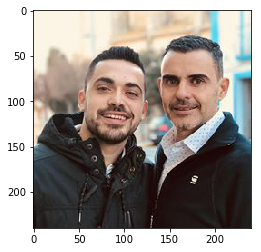

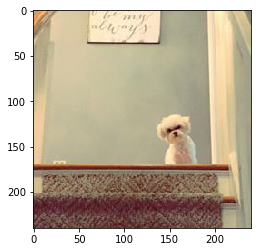

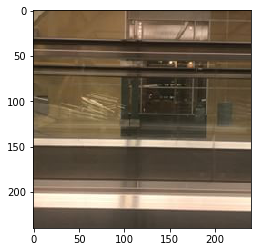

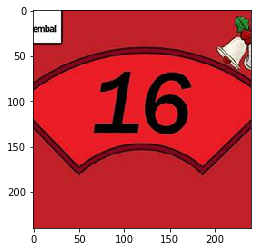

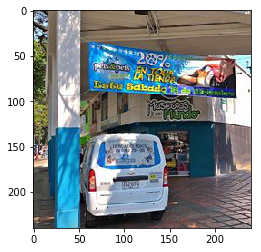

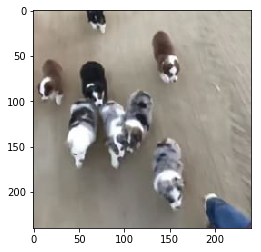

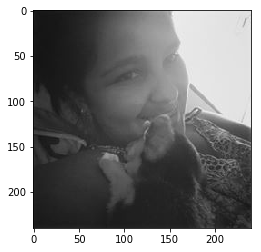

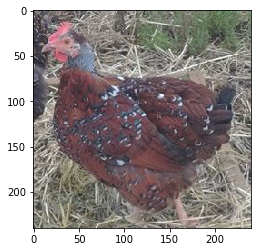

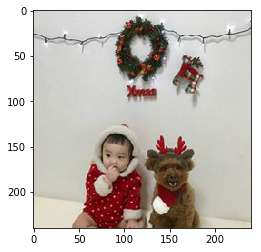

In [100]:
tmp = tf_get_images(list(src[(src.label=='inst-pet') & (src.fcst_pet < 0.2)].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

In [102]:
src[(src.label=='inst-pet') & (src.fcst_food > 0.9)]

f0000     f0001     f0002     f0003     f0004     f0005     f0006  \
2882 -3.975063 -0.021848  3.017172 -4.318068 -3.952288 -3.194212 -2.548248   

         f0007     f0008     f0009    ...        f0997     f0998     f0999  \
2882 -5.783592  2.027052  0.899378    ...     6.831322  0.234668  6.268521   

        f1000                       file     label  fcst_bar  fcst_beach  \
2882 -0.42524  data\inst-pet\pic_059.jpg  inst-pet  0.010934    0.000872   

      fcst_food  fcst_pet  
2882   0.973429  0.992179  

[1 rows x 1007 columns]

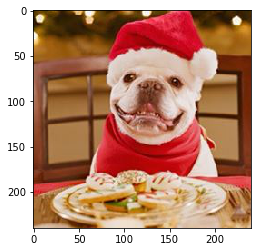

In [103]:
tmp = tf_get_images(list(src[(src.label=='inst-pet') & (src.fcst_food > 0.9)].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

In [104]:
src[(src.label=='inst-pet') & (src.fcst_bar > 0.9)]

f0000     f0001     f0002    f0003     f0004    f0005    f0006  \
2842 -3.148004 -1.268357  0.976818 -0.77923 -3.285876 -2.46848  0.87332   

         f0007     f0008     f0009    ...        f0997     f0998    f0999  \
2842 -5.018451 -2.234644 -0.928638    ...    -1.419733 -3.886355  1.16607   

         f1000                       file     label  fcst_bar  fcst_beach  \
2842 -0.264364  data\inst-pet\pic_019.jpg  inst-pet  0.925644    0.005019   

      fcst_food  fcst_pet  
2842   0.002139  0.000309  

[1 rows x 1007 columns]

In [107]:
src[(src.label=='inst-beach') & (src.fcst_pet > 0.9)]

f0000     f0001     f0002     f0003     f0004     f0005     f0006  \
2795 -3.788256 -2.897100 -2.280771 -2.079266  2.088605 -1.486757  2.225514   
2799 -3.653045 -1.107453  4.044296 -0.704256 -1.112612 -2.005824 -1.141982   

         f0007     f0008     f0009    ...        f0997     f0998     f0999  \
2795 -1.815985 -2.985394 -3.360342    ...     1.281684 -5.615826 -0.894953   
2799 -2.208805 -0.779576  1.225844    ...    -0.668607 -6.973330  0.332764   

         f1000                         file       label  fcst_bar  fcst_beach  \
2795  0.377375  data\inst-beach\pic_031.jpg  inst-beach  0.011299    0.006134   
2799  1.310594  data\inst-beach\pic_035.jpg  inst-beach  0.004825    0.003583   

      fcst_food  fcst_pet  
2795   0.001408  0.999648  
2799   0.004862  0.998120  

[2 rows x 1007 columns]

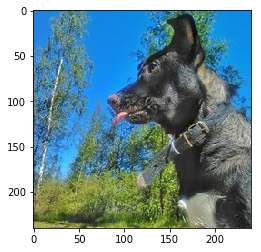

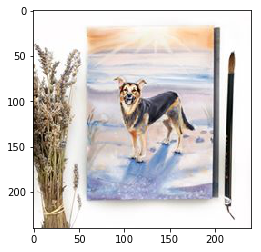

In [108]:
tmp = tf_get_images(list(src[(src.label=='inst-beach') & (src.fcst_pet > 0.9)].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

In [113]:
src[(src.label=='inst-beach') & (src.fcst_beach < 0.005)]

f0000     f0001     f0002     f0003     f0004     f0005     f0006  \
2787 -3.620334 -2.285113 -4.452731 -3.378614 -2.716130 -0.476201 -1.045560   
2788 -3.406515  5.422470  8.122671 -1.756408 -0.597987  0.278273  0.285189   
2798 -3.250621 -0.674706 -2.929049  1.159466 -1.096207  2.095358  2.004979   
2799 -3.653045 -1.107453  4.044296 -0.704256 -1.112612 -2.005824 -1.141982   
2801 -3.415610  0.538628 -0.727396 -0.902043  1.803628  1.195961  1.084980   
2811 -3.885710 -0.523590 -1.920137 -1.821619 -3.512450 -0.236797  0.491902   

         f0007     f0008     f0009    ...        f0997     f0998     f0999  \
2787 -2.739758 -3.061188 -4.515453    ...     0.506823 -5.159624  2.405375   
2788 -2.518445  0.856621  1.187889    ...     3.127529  0.911027  5.937188   
2798  0.901044 -0.709354 -2.824801    ...    -0.641341 -0.688167  1.516618   
2799 -2.208805 -0.779576  1.225844    ...    -0.668607 -6.973330  0.332764   
2801 -3.327596 -3.240188 -2.732532    ...     2.124784 -2.178869  2.999845   
2811 -4.570500 -0.410302 -3.755338    ...     0.100935 -4.744473 -0.297408   

         f1000                         file       label  fcst_bar  fcst_beach  \
2787  6.129986  data\inst-beach\pic_023.jpg  inst-beach  0.968200    0.001086   
2788  0.087657  data\inst-beach\pic_024.jpg  inst-beach  0.355593    0.002099   
2798 -0.209853  data\inst-beach\pic_034.jpg  inst-beach  0.984743    0.001170   
2799  1.310594  data\inst-beach\pic_035.jpg  inst-beach  0.004825    0.003583   
2801 -0.460767  data\inst-beach\pic_037.jpg  inst-beach  0.977275    0.001473   
2811 -2.014870  data\inst-beach\pic_047.jpg  inst-beach  0.908963    0.003205   

      fcst_food  fcst_pet  
2787   0.003569  0.001013  
2788   0.200720  0.000739  
2798   0.001236  0.001771  
2799   0.004862  0.998120  
2801   0.001297  0.000420  
2811   0.001236  0.000275  

[6 rows x 1007 columns]

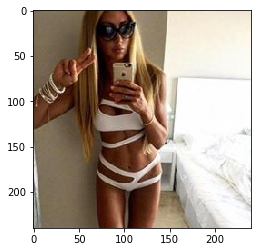

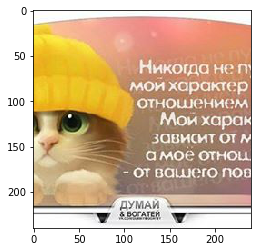

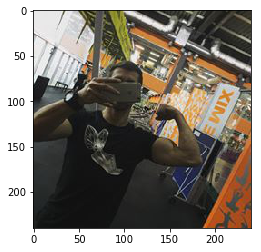

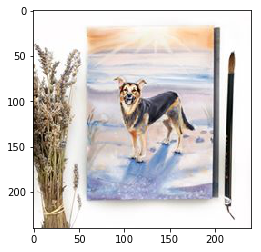

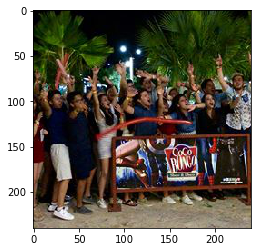

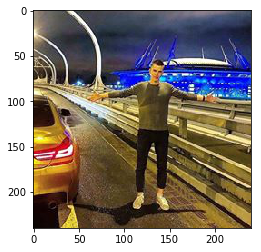

In [114]:
tmp = tf_get_images(list(src[(src.label=='inst-beach') & (src.fcst_beach < 0.005)].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

In [127]:
src_r = src[(src.label=='random')&(src.fcst_bar < 0.5)]

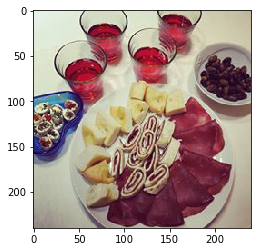

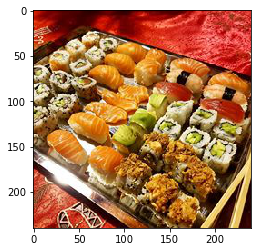

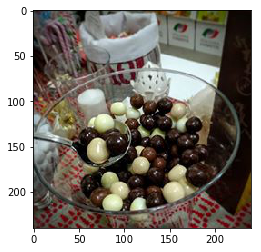

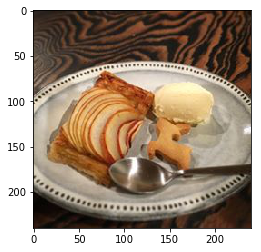

In [131]:
tmp = tf_get_images(list(src_r[src_r.fcst_food>0.9].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

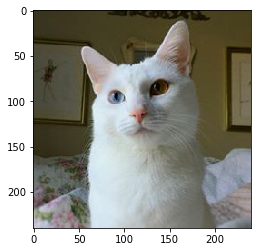

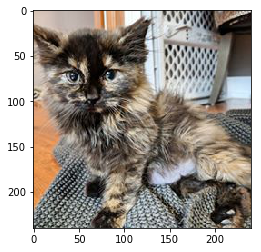

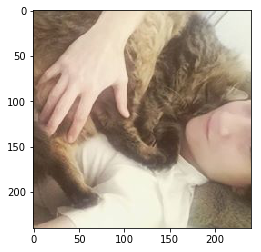

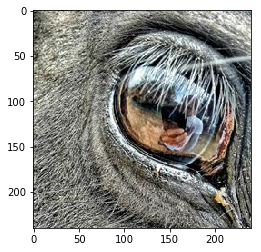

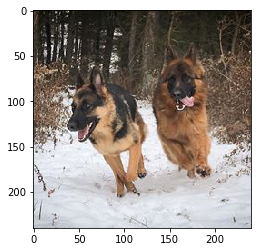

In [130]:
tmp = tf_get_images(list(src_r[src_r.fcst_pet>0.9].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

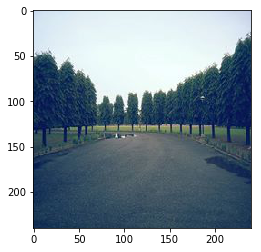

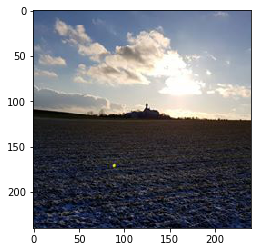

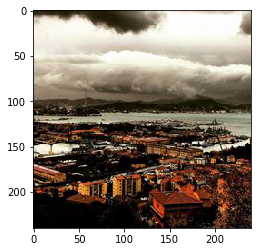

In [132]:
tmp = tf_get_images(list(src_r[src_r.fcst_beach>0.9].file))
for img in tmp:
    plt.imshow(img)
    plt.show()

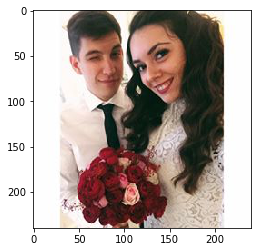

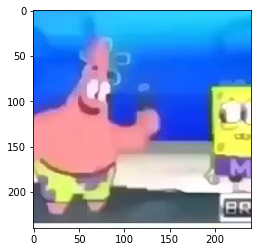

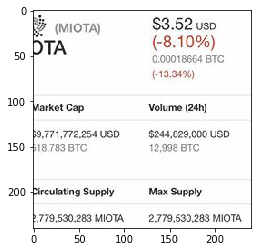

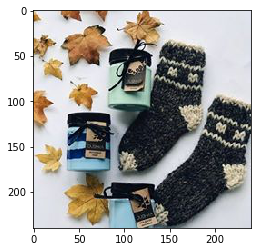

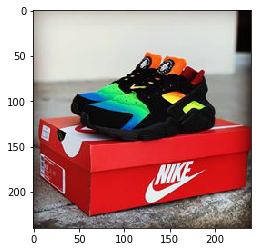

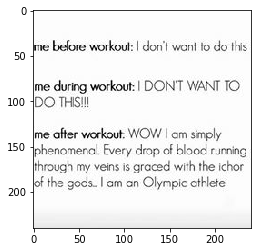

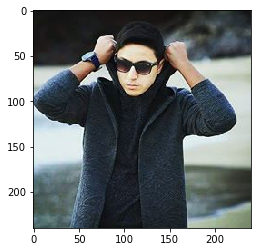

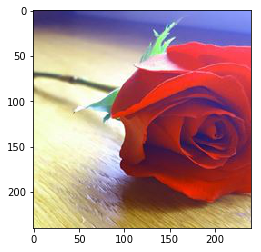

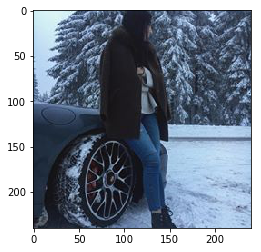

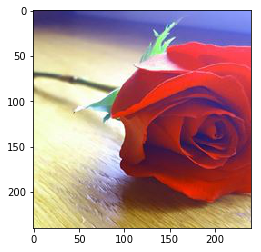

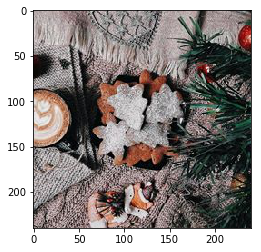

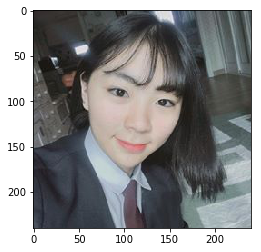

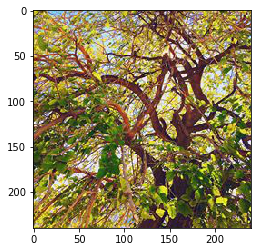

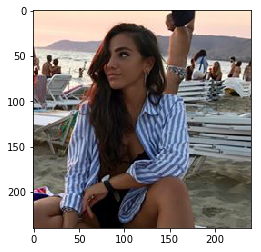

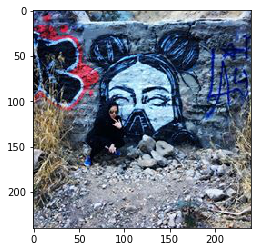

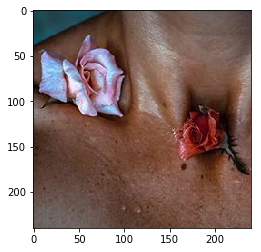

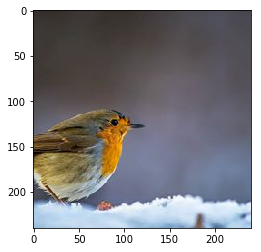

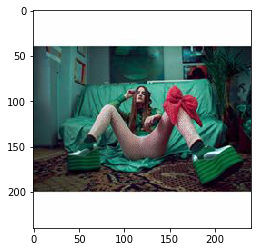

In [134]:
tmp = tf_get_images(list(src_r[src_r.fcst_beach+src_r.fcst_food+src_r.fcst_pet<0.8].file))
for img in tmp:
    plt.imshow(img)
    plt.show()